In [1]:
# Import libraries to use 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14'}

In [2]:
# This definition is used to run the netlist in ngspice and load the data generated by the program. 

def readdata(filename,Labels):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    #data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print line
        # Here we initialize the ngspice data array
        
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]
                    #print(r, index [c])

                    data [r][index[c]] = temp_data [c]

                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data

In [3]:
# Definitions for the resistance calculation 

def T_gradient(x,Tmax): # x = [mm], T = [K]
    b = (77-Tmax)/18
    T = Tmax + b*x
    return T

def resistivity_cu(T): # [Ohm m]
    rho_cu = (0.2E-8)+((1.48E-8)/216)*(T-77)
    return rho_cu

def resistivity_vox(T):
    rho = (403.18-1.34*T)/100 # The resulting resistivity is in Ohm meters
    return rho

def Rcu_strip(rho,l,tc,w_cu):#[Ohm]
    Rcu = rho*l/(tc*w_cu)
    return Rcu

def Rcu_stabilizer(rho,l,ts,w): #[Ohm]
    Rs = rho*l/(ts*w)
    return Rs

def Rl_vox(rho,l,w,tf): 
    Rl = rho*l/(tf*w)
    return Rl
    
def Rt_vox(rho,l,w,tf):
    Rt = rho*tf/(l*w)
    return Rt

def R_contact(rho,l,w_cu): #[Ohm]
    Rc = rho/(l*w_cu)
    return Rc
    
def resistances(Tmax):
    l = 6E-3 # [m] Distance between pins for voltage taps
    w = 4E-3 # [m] Width of the tape
    w_cu = 3E-3 # [m] Width of cu strip
    tf = 0.5E-6 # [m] Thickness of the VO film
    tc = 1E-3 # [m] Thickness of Cu tape on top 
    ts = 20E-6 # [m] Thickness of the Cu stabilizer in ReBCO tape 
    rho_contact = 100E-10 # [Ohm m^2]
    
    x = np.array([18,12,6,0]) # Position of section V7,V8,V9,V10
    T = T_gradient(x,Tmax) 
    rho_cu = resistivity_cu(T)
    rho_vox = resistivity_vox(T)
    #print(f'Vox resistivity {rho_vox}')
    #print(f'Vcu resistivity {rho_cu}')
    
    Rcu = Rcu_strip(rho_cu,l,tc,w_cu)
    Rc = R_contact(rho_contact,l,w_cu)
    Rs = Rcu_stabilizer(rho_cu,l,ts,w)
    Rft = Rt_vox(rho_vox,l,w,tf)
    Rfl = Rl_vox(rho_vox,l,w,tf)
    
    return Rcu,Rc,Rs,Rft,Rfl

# Function to generate netlist for heater experiment in ngspice
def generatenetlist_with_VOx(filename,Imax,Ic,n,Rcu,Rc,Rs,Rft,Rfl):

    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in cu strip sections
    for i in range(12):
        Labels.append(f'v({i+1})')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)

    
    with open(filename, 'w') as output:
        output.write(f'* Netlist for heater without coating\n') # Name of the circuit as a comment
        output.write('I1 0 N031 120\n') # Current source
        
        # Hts voltage sources
        output.write(f'B1 S2 0 V=0.6E-6*pow((I(B1)/{Ic}),{n})\n')
        output.write(f'B2 S3 S2 V=0.6E-6*pow((I(B2)/{Ic}),{n})\n')
        output.write(f'B3 S4 S3 V=0.6E-6*pow((I(B3)/{Ic}),{n})\n')
        output.write(f'B4 S5 S4 V=0.6E-6*pow((I(B4)/{Ic}),{n})\n')
        output.write(f'B10 S11 S10 V=0.6E-6*pow((I(B10)/{Ic}),{n})\n')
        output.write(f'B11 S12 S11 V=0.6E-6*pow((I(B11)/{Ic}),{n})\n')
        output.write(f'B12 N031 S12 V=0.6E-6*pow((I(B12)/{Ic}),{n}))\n')
        
        # Cu strip resistances
        output.write(f'Rcu1 2 1 {Rcu[0]}\n')
        output.write(f'Rcu2 3 2 {Rcu[0]}\n')
        output.write(f'Rcu3 4 3 {Rcu[0]}\n')
        output.write(f'Rcu4 5 4 {Rcu[0]}\n')
        output.write(f'Rcu5 6 5 {Rcu[1]}\n')
        output.write(f'Rcu6 7 6 {Rcu[2]}\n')
        output.write(f'Rcu7 8 7 {Rcu[3]}\n')
        output.write(f'Rcu8 9 8 {Rcu[2]}\n')
        output.write(f'Rcu9 10 9 {Rcu[1]}\n')
        output.write(f'Rcu10 11 10 {Rcu[0]}\n')
        output.write(f'Rcu11 12 11 {Rcu[0]}\n')   
        output.write(f'Rcu12 13 12 {Rcu[0]}\n')
        
        # Contact resistances
        output.write(f'Rc1 1 N001 {Rc}\n')
        output.write(f'Rc2 2 N002 {Rc}\n')
        output.write(f'Rc3 3 N003 {Rc}\n')
        output.write(f'Rc4 4 N004 {Rc}\n')
        output.write(f'Rc5 5 N005 {Rc}\n')
        output.write(f'Rc6 6 N006 {Rc}\n')
        output.write(f'Rc7 7 N007 {Rc}\n')
        output.write(f'Rc8 8 N008 {Rc}\n')
        output.write(f'Rc9 9 N009 {Rc}\n')
        output.write(f'Rc10 10 N010 {Rc}\n')
        output.write(f'Rc11 11 N011 {Rc}\n')
        output.write(f'Rc12 12 N012 {Rc}\n')
        output.write(f'Rc13 13 N013 {Rc}\n')
        
        output.write(f'Rc14 N014 0 {Rc}\n')
        output.write(f'Rc15 N015 S2 {Rc}\n')
        output.write(f'Rc16 N016 S3 {Rc}\n')
        output.write(f'Rc17 N017 S4 {Rc}\n')
        output.write(f'Rc18 N018 S5 {Rc}\n')
        output.write(f'Rc19 N019 N027 {Rc}\n')
        output.write(f'Rc20 N020 N028 {Rc}\n')
        output.write(f'Rc21 N021 N029 {Rc}\n')
        output.write(f'Rc22 N022 N030 {Rc}\n')
        output.write(f'Rc23 N023 S10 {Rc}\n')
        output.write(f'Rc24 N024 S11 {Rc}\n')
        output.write(f'Rc25 N025 S12 {Rc}\n')
        output.write(f'Rc26 N026 N031 {Rc}\n')

        # Cu stabilizer resistances
        output.write(f'Rs1 S2 0 {Rs[0]}\n')
        output.write(f'Rs2 S3 S2 {Rs[0]}\n')
        output.write(f'Rs3 S4 S3 {Rs[0]}\n')
        output.write(f'Rs4 S5 S4 {Rs[0]}\n')
        output.write(f'Rs5 N027 S5 {Rs[1]}\n')
        output.write(f'Rs6 N028 N027 {Rs[2]}\n')
        output.write(f'Rs7 N029 N028 {Rs[3]}\n')
        output.write(f'Rs8 N030 N029 {Rs[2]}\n')
        output.write(f'Rs9 S10 N030 {Rs[1]}\n')
        output.write(f'Rs10 S11 S10 {Rs[0]}\n')
        output.write(f'Rs11 S12 S11 {Rs[0]}\n')
        output.write(f'Rs12 N031 S12 {Rs[0]}\n')

        
        # VOx Transverse resistances
        output.write(f'Rft1 N001 N014 {Rft[0]}\n')
        output.write(f'Rft2 N002 N015 {Rft[0]}\n')
        output.write(f'Rft3 N003 N016 {Rft[0]}\n')
        output.write(f'Rft4 N004 N017 {Rft[0]}\n')
        output.write(f'Rft5 N005 N018 {Rft[1]}\n')
        output.write(f'Rft6 N006 N019 {Rft[2]}\n')
        output.write(f'Rft7 N007 N020 {Rft[3]}\n')
        output.write(f'Rft8 N008 N021 {Rft[3]}\n')
        output.write(f'Rft9 N009 N022 {Rft[2]}\n')
        output.write(f'Rft10 N010 N023 {Rft[1]}\n')
        output.write(f'Rft11 N011 N024 {Rft[0]}\n')
        output.write(f'Rft12 N012 N025 {Rft[0]}\n')
        output.write(f'Rft13 N013 N026 {Rft[0]}\n')
        
        # VOx Longitudinal resistances
        output.write(f'Rfl1 N002 N001 {Rfl[0]}\n')
        output.write(f'Rfl2 N003 N002 {Rfl[0]}\n')
        output.write(f'Rfl3 N004 N003 {Rfl[0]}\n')
        output.write(f'Rfl4 N005 N004 {Rfl[0]}\n')
        output.write(f'Rfl5 N006 N005 {Rfl[1]}\n')
        output.write(f'Rfl6 N007 N006 {Rfl[2]}\n')
        output.write(f'Rfl7 N008 N007 {Rfl[3]}\n')
        output.write(f'Rfl8 N009 N008 {Rfl[2]}\n')
        output.write(f'Rfl9 N010 N009 {Rfl[1]}\n')
        output.write(f'Rfl10 N011 N010 {Rfl[0]}\n')
        output.write(f'Rfl11 N012 N011 {Rfl[0]}\n')
        output.write(f'Rfl12 N013 N012 {Rfl[0]}\n')
        
        output.write(f'.dc I1 0 {Imax} {Imax}\n')        
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
        
    return Labels

def generatenetlist_without_VOx(filename,Imax,Ic,n,Rcu,Rc,Rs):

    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in cu strip sections
    for i in range(12):
        Labels.append(f'v({i+1})')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)

    
    with open(filename, 'w') as output:
        output.write(f'* Netlist for heater without coating\n') # Name of the circuit as a comment
        output.write('I1 0 N005 100\n') # Current source
        # Hts voltage sources
        output.write(f'B1 S2 0 V=0.6E-6*pow((I(B1)/{Ic}),{n})\n')
        output.write(f'B2 S3 S2 V=0.6E-6*pow((I(B2)/{Ic}),{n})\n')
        output.write(f'B3 S4 S3 V=0.6E-6*pow((I(B3)/{Ic}),{n})\n')
        output.write(f'B4 S5 S4 V=0.6E-6*pow((I(B4)/{Ic}),{n})\n')
        output.write(f'B10 S11 S10 V=0.6E-6*pow((I(B10)/{Ic}),{n})\n')
        output.write(f'B11 S12 S11 V=0.6E-6*pow((I(B11)/{Ic}),{n})\n')
        output.write(f'B12 N005 S12 V=0.6E-6*pow((I(B12)/{Ic}),{n})\n')
        
        # Cu strip resistances
        output.write(f'Rcu1 2 1 {Rcu[0]}\n')
        output.write(f'Rcu2 3 2 {Rcu[0]}\n')
        output.write(f'Rcu3 4 3 {Rcu[0]}\n')
        output.write(f'Rcu4 5 4 {Rcu[0]}\n')
        output.write(f'Rcu5 6 5 {Rcu[1]}\n')
        output.write(f'Rcu6 7 6 {Rcu[2]}\n')
        output.write(f'Rcu7 8 7 {Rcu[3]}\n')
        output.write(f'Rcu8 9 8 {Rcu[2]}\n')
        output.write(f'Rcu9 10 9 {Rcu[1]}\n')
        output.write(f'Rcu10 11 10 {Rcu[0]}\n')
        output.write(f'Rcu11 12 11 {Rcu[0]}\n')   
        output.write(f'Rcu12 13 12 {Rcu[0]}\n')
        
        # Contact resistances
        output.write(f'Rc1 1 0 {Rc}\n')
        output.write(f'Rc2 2 S2 {Rc}\n')
        output.write(f'Rc3 3 S3 {Rc}\n')
        output.write(f'Rc4 4 S4 {Rc}\n')
        output.write(f'Rc5 5 S5 {Rc}\n')
        output.write(f'Rc6 6 N001 {Rc}\n')
        output.write(f'Rc7 7 N002 {Rc}\n')
        output.write(f'Rc8 8 N003 {Rc}\n')
        output.write(f'Rc9 9 N004 {Rc}\n')
        output.write(f'Rc10 10 S10 {Rc}\n')
        output.write(f'Rc11 11 S11 {Rc}\n')
        output.write(f'Rc12 12 S12 {Rc}\n')
        output.write(f'Rc13 13 N005 {Rc}\n')
        
        # Cu stabilizer resistances
        output.write(f'Rs1 S2 0 {Rs[0]}\n')
        output.write(f'Rs2 S3 S2 {Rs[0]}\n')
        output.write(f'Rs3 S4 S3 {Rs[0]}\n')
        output.write(f'Rs4 S5 S4 {Rs[0]}\n')
        output.write(f'Rs5 N001 S5 {Rs[1]}\n')
        output.write(f'Rs6 N002 N001 {Rs[2]}\n')
        output.write(f'Rs7 N003 N002 {Rs[3]}\n')
        output.write(f'Rs8 N004 N003 {Rs[2]}\n')
        output.write(f'Rs9 S10 N004 {Rs[1]}\n')
        output.write(f'Rs10 S11 S10 {Rs[0]}\n')
        output.write(f'Rs11 S12 S11 {Rs[0]}\n')
        output.write(f'Rs12 N005 S12 {Rs[0]}\n')

        
        output.write(f'.dc I1 0 {Imax} {Imax}\n')        
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
        
    return Labels

In [20]:
# Test for a certain value of temperature max for case with coating

filename = 'Heater_w_VOx.cir'
Tmax = 275
Imax = 85
Ic = 95.13 
n = 32.45

Rcu,Rc,Rs,Rft,Rfl = resistances(Tmax)
Labels = generatenetlist_with_VOx(filename,Imax,Ic,n,Rcu,Rc,Rs,Rft,Rfl)
data = readdata(filename,Labels)

voltages = np.zeros((12,(len(data[:,0]))))
for i in range(11):
    voltages[i] = data[:,3+i]-data[:,2+i]
    print(f'V{i+1}(85 A) = {voltages[i,-1]/1E-6} microVolts')

V1(85 A) = 8.100000000010876 microVolts
V2(85 A) = 16.199999999994 microVolts
V3(85 A) = 24.200000000002 microVolts
V4(85 A) = 32.40000000001575 microVolts
V5(85 A) = 142.49999999998985 microVolts
V6(85 A) = 317.90000000000987 microVolts
V7(85 A) = 576.299999999974 microVolts
V8(85 A) = 295.9000000000156 microVolts
V9(85 A) = 125.09999999998911 microVolts
V10(85 A) = 26.100000000001124 microVolts
V11(85 A) = 17.400000000000748 microVolts


<IPython.core.display.Javascript object>


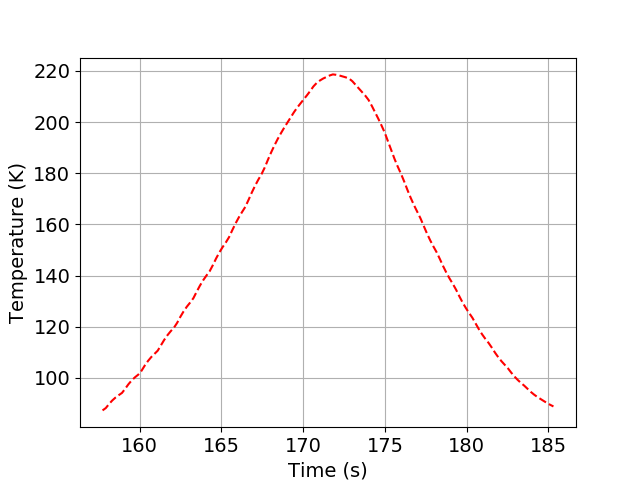

Text(0, 0.5, 'Temperature (K)')

In [46]:
# Extracting data from experiment for temperature profile
%matplotlib notebook

data = pd.read_csv('tape18_w_Cu_strip_2019-11-12-12-50-32.csv')
init_val = 795
final_val = 935
time = np.asarray(data['time'][init_val:final_val])
Temperatures = np.asarray(data['T2_m'][init_val:final_val])

plt.grid()
plt.plot(time,Temperatures,'--r')
plt.xlabel('Time (s)',**axis_font)
plt.ylabel('Temperature (K)',**axis_font)

<IPython.core.display.Javascript object>


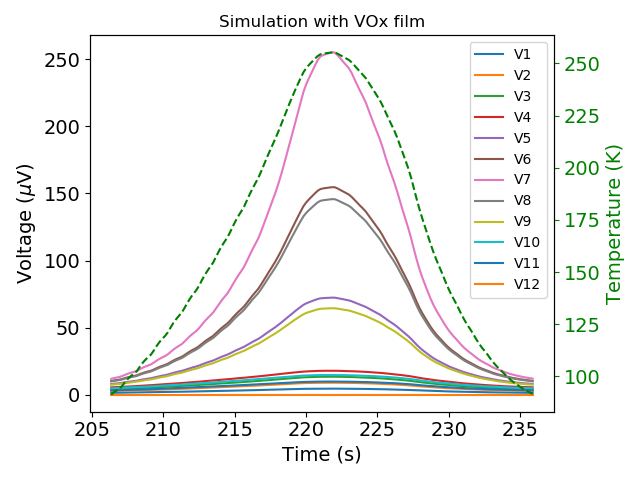

In [26]:
# Test for Fig 7, heater experiment on tape 18 with Cu on top
%matplotlib notebook
filename = 'Heater_w_VOx.cir'
Tmax = 255
Imax = 50
Ic = 78.72 
n = 34.17

#Temperatures = np.arange(90,Tmax,10)
#time = np.arange(0,len(Temperatures),1)
V1 = []
V2 = []
V3 = []
V4 = []
V5 = []
V6 = []
V7 = []
V8 = []
V9 = []
V10 = []
V11 = []
V12 = []

for i in range(len(Temperatures)):
    T = Temperatures[i]
    
    Rcu,Rc,Rs,Rft,Rfl = resistances(T)
    Labels = generatenetlist_with_VOx(filename,Imax,Ic,n,Rcu,Rc,Rs,Rft,Rfl)
    data = readdata(filename,Labels)

    voltages = np.zeros((12,(len(data[:,0]))))
    for j in range(11):
        voltages[j] = data[:,3+j]-data[:,2+j]
        #plt.plot(T,voltages[i,-1]/1e-6,'o',label=f'V{i+1}')
    V1.append(voltages[0,-1])
    V2.append(voltages[1,-1])
    V3.append(voltages[2,-1])
    V4.append(voltages[3,-1])
    V5.append(voltages[4,-1])
    V6.append(voltages[5,-1])
    V7.append(voltages[6,-1])
    V8.append(voltages[7,-1])
    V9.append(voltages[8,-1])
    V10.append(voltages[9,-1])
    V11.append(voltages[10,-1])
    V12.append(voltages[11,-1])
    #plt.plot(time[i],voltages[6,-1]/1e-6,'o')

V1 = np.asarray(V1)
V2 = np.asarray(V2)
V3 = np.asarray(V3)
V4 = np.asarray(V4)
V5 = np.asarray(V5)
V6 = np.asarray(V6)
V7 = np.asarray(V7)
V8 = np.asarray(V8)
V9 = np.asarray(V9)
V10 = np.asarray(V10)
V11 = np.asarray(V11)
V12 = np.asarray(V12)

fig,ax = plt.subplots()

ax.plot(time,V1/1e-6,label = 'V1')
ax.plot(time,V2/1e-6,label = 'V2')
ax.plot(time,V3/1e-6,label = 'V3')
ax.plot(time,V4/1e-6,label = 'V4')
ax.plot(time,V5/1e-6,label = 'V5')
ax.plot(time,V6/1e-6,label = 'V6')
ax.plot(time,V7/1e-6,label = 'V7')
ax.plot(time,V8/1e-6,label = 'V8')
ax.plot(time,V9/1e-6,label = 'V9')
ax.plot(time,V10/1e-6,label = 'V10')
ax.plot(time,V11/1e-6,label = 'V11')
ax.plot(time,V12/1e-6,label = 'V12')
ax.set_xlabel('Time (s)',**axis_font)
ax.set_ylabel('Voltage ($\mu$V)',**axis_font)
#ax.grid()
ax.legend()
ax2 = ax.twinx()

ax2.plot(time,Temperatures,'--g')
ax2.set_ylabel('Temperature (K)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')
plt.title('Simulation with VOx film')

plt.tight_layout()

plt.savefig('tape18_sim_wVOx.png',dpi=300)
plt.show()

V7_w_VOx = V7

<IPython.core.display.Javascript object>


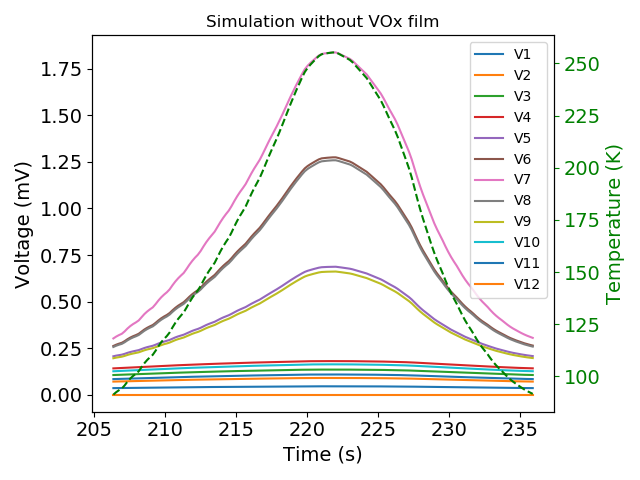

In [27]:

# Test for Fig 7, heater experiment on tape 18 with Cu on top
#%matplotlib notebook
filename = 'Heater_wo_VOx.cir'
Tmax = 255
Imax = 71
Ic = 78.72 
n = 34.17

#Temperatures = np.arange(90,Tmax,1)
V1 = []
V2 = []
V3 = []
V4 = []
V5 = []
V6 = []
V7 = []
V8 = []
V9 = []
V10 = []
V11 = []
V12 = []

for i in range(len(Temperatures)):
    T = Temperatures[i]
    Rcu,Rc,Rs,Rft,Rfl = resistances(T)
    Labels = generatenetlist_without_VOx(filename,Imax,Ic,n,Rcu,Rc*2,Rs)
    data = readdata(filename,Labels)


    voltages = np.zeros((12,(len(data[:,0]))))
    for j in range(11):
        voltages[j] = data[:,3+j]-data[:,2+j]
        #plt.plot(T,voltages[i,-1]/1e-6,'o',label=f'V{i+1}')
    V1.append(voltages[0,-1])
    V2.append(voltages[1,-1])
    V3.append(voltages[2,-1])
    V4.append(voltages[3,-1])
    V5.append(voltages[4,-1])
    V6.append(voltages[5,-1])
    V7.append(voltages[6,-1])
    V8.append(voltages[7,-1])
    V9.append(voltages[8,-1])
    V10.append(voltages[9,-1])
    V11.append(voltages[10,-1])
    V12.append(voltages[11,-1])
    #plt.plot(time[i],voltages[6,-1]/1e-6,'o')

V1 = np.asarray(V1)
V2 = np.asarray(V2)
V3 = np.asarray(V3)
V4 = np.asarray(V4)
V5 = np.asarray(V5)
V6 = np.asarray(V6)
V7 = np.asarray(V7)
V8 = np.asarray(V8)
V9 = np.asarray(V9)
V10 = np.asarray(V10)
V11 = np.asarray(V11)
V12 = np.asarray(V12)

fig,ax = plt.subplots()

ax.plot(time,V1/1e-3,label = 'V1')
ax.plot(time,V2/1e-3,label = 'V2')
ax.plot(time,V3/1e-3,label = 'V3')
ax.plot(time,V4/1e-3,label = 'V4')
ax.plot(time,V5/1e-3,label = 'V5')
ax.plot(time,V6/1e-3,label = 'V6')
ax.plot(time,V7/1e-3,label = 'V7')
ax.plot(time,V8/1e-3,label = 'V8')
ax.plot(time,V9/1e-3,label = 'V9')
ax.plot(time,V10/1e-3,label = 'V10')
ax.plot(time,V11/1e-3,label = 'V11')
ax.plot(time,V12/1e-3,label = 'V12')
ax.set_xlabel('Time (s)',**axis_font)
ax.set_ylabel('Voltage (mV)',**axis_font)
ax.legend()
#ax.grid()
ax2 = ax.twinx()

ax2.plot(time,Temperatures,'--g')
ax2.set_ylabel('Temperature (K)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')
plt.title('Simulation without VOx film')
plt.tight_layout()

plt.savefig('Tape18_sim_woVOx.png',dpi=300)

plt.show()
V7_wo_VOx = V7

<IPython.core.display.Javascript object>


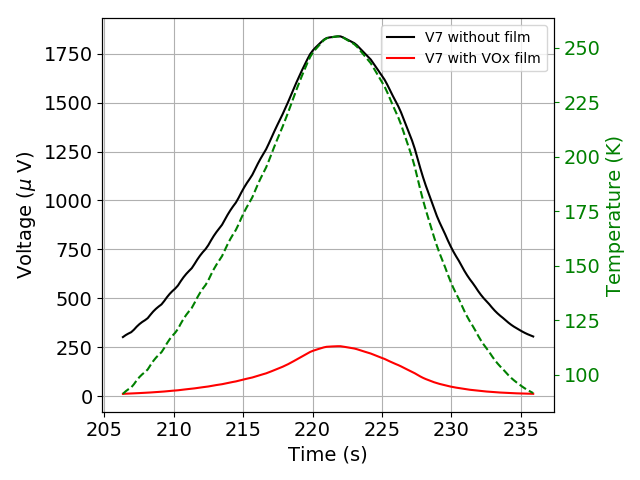

In [32]:
#%matplotlib notebook

fig,ax = plt.subplots()
ax.plot(time,V7_wo_VOx/1e-6,'k',label = 'V7 without film')
ax.plot(time,V7_w_VOx/1e-6,'r',label = 'V7 with VOx film')
ax.set_xlabel('Time (s)',**axis_font)
ax.set_ylabel('Voltage ($\mu$ V)',**axis_font)
ax.legend()
ax.grid()
ax2 = ax.twinx()
ax2.plot(time,Temperatures,'--g')
ax2.set_ylabel('Temperature (K)',color = 'g',**axis_font)
ax2.tick_params(axis='y', colors='g')

#plt.savefig('Tape18_sim_w&woVOx.png',dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
* C:\Users\acaraujomartinez\OneDrive - Universidad de Guanajuato\Documents\Circuit model for Short sample-LTSPICE\Simulations\Ngspice model\Heater\Heater - RT.asc
I1 0 N031 120
B1 S2 0 V=0.6E-6*pow((I(B1)/{Ic}),{n})
B2 S3 S2 V=0.6E-6*pow((I(B2)/{Ic}),{n})
B3 S4 S3 V=0.6E-6*pow((I(B3)/{Ic}),{n})
B4 S5 S4 V=0.6E-6*pow((I(B4)/{Ic}),{n})
B10 S11 S10 V=0.6E-6*pow((I(B10)/{Ic}),{n})
B11 S12 S11 V=0.6E-6*pow((I(B11)/{Ic}),{n})
B12 N031 S12 V=0.6E-6*pow((I(B12)/{Ic}),{n})

Rcu1 2 1 {Rcu}
Rcu2 3 2 {Rcu}
Rcu3 4 3 {Rcu}
Rcu4 5 4 {Rcu}
Rcu5 6 5 1.30444444E-05
Rcu6 7 6 2.20888889E-05
Rcu7 8 7 3.11333333E-05
Rcu8 9 8 2.20888889E-05
Rcu9 10 9 1.30444444E-05
Rcu10 11 10 {Rcu}
Rcu11 12 11 {Rcu}
Rcu12 13 12 {Rcu}

Rc1 1 N001 {Rc}
Rc2 2 N002 {Rc}
Rc3 3 N003 {Rc}
Rc4 4 N004 {Rc}
Rc5 5 N005 {Rc}
Rc6 6 N006 {Rc}
Rc7 7 N007 {Rc}
Rc8 8 N008 {Rc}
Rc9 9 N009 {Rc}
Rc10 10 N010 {Rc}
Rc11 11 N011 {Rc}
Rc12 12 N012 {Rc}
Rc13 13 N013 {Rc}
Rc14 N014 0 {Rc}
Rc15 N015 S2 {Rc}
Rc16 N016 S3 {Rc}
Rc17 N017 S4 {Rc}
Rc18 N018 S5 {Rc}
Rc19 N019 N027 {Rc}
Rc20 N020 N028 {Rc}
Rc21 N021 N029 {Rc}
Rc22 N022 N030 {Rc}
Rc23 N023 S10 {Rc}
Rc24 N024 S11 {Rc}
Rc25 N025 S12 {Rc}
Rc26 N026 N031 {Rc}

Rs1 S2 0 {Rs}
Rs2 S3 S2 {Rs}
Rs3 S4 S3 {Rs}
Rs4 S5 S4 {Rs}
Rs5 N027 S5 0.00048917
Rs6 N028 N027 0.00082833
Rs7 N029 N028 0.0011675
Rs8 N030 N029 0.00082833
Rs9 S10 N030 0.00048917
Rs10 S11 S10 {Rs}
Rs11 S12 S11 {Rs}
Rs12 N031 S12 {Rs}


Rft1 N001 N014 {Rf}
Rft2 N002 N015 {Rf}
Rft3 N003 N016 {Rf}
Rft4 N004 N017 {Rf}
Rft5 N005 N018 0.044075
Rft6 N006 N019 0.02565
Rft7 N007 N020 0.007225
Rft8 N008 N021 0.007225
Rft9 N009 N022 0.02565
Rft10 N010 N023 0.044075
Rft11 N011 N024 {Rf}
Rft12 N012 N025 {Rf}
Rft13 N013 N026 {Rf}

Rfl1 N002 N001 {Rfl}
Rfl2 N003 N002 {Rfl}
Rfl3 N004 N003 {Rfl}
Rfl4 N005 N004 {Rfl}
Rfl5 N006 N005 6346800
Rfl6 N007 N006 3693600
Rfl7 N008 N007 1040400
Rfl8 N009 N008 3693600
Rfl9 N010 N009 6346800
Rfl10 N011 N010 {Rfl}
Rfl11 N012 N011 {Rfl}
Rfl12 N013 N012 {Rfl}
.dc I1 0 85
.param Rc=555E-6 Rs=1.5E-4 Rcu=4E-6 Rf=.0625 Ic=95.13 n=32.45 Ic2=95.13 n2=32.45 Rfl=9E6
.backanno
.end
